In [11]:
from deepchem.molnet import load_bace_classification
from deepchem.feat import CircularFingerprint
from deepchem.data import NumpyDataset
from deepchem.models import GraphConvModel
from deepchem.feat.graph_features import ConvMolFeaturizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from collections import Counter
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [12]:
# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
RDLogger.DisableLog('rdApp.*')

In [13]:
tasks, datasets, transformers = load_bace_classification(featurizer='Raw', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

### ECFP (for sklearn's models and NN)

In [14]:
ecfp_featurizer = CircularFingerprint(size=2048)

ecfp_train = ecfp_featurizer.featurize(train_dataset.X)
ecfp_valid = ecfp_featurizer.featurize(valid_dataset.X)

train_dataset_ecfp = NumpyDataset(ecfp_train, train_dataset.y, train_dataset.w, train_dataset.ids)
valid_dataset_ecfp = NumpyDataset(ecfp_valid, valid_dataset.y, valid_dataset.w, valid_dataset.ids)

X_trainval = np.concatenate([train_dataset_ecfp.X, valid_dataset_ecfp.X], axis=0)
y_trainval = np.concatenate([train_dataset_ecfp.y, valid_dataset_ecfp.y], axis=0)
w_trainval = np.concatenate([train_dataset_ecfp.w, valid_dataset_ecfp.w], axis=0)
ids_trainval = np.concatenate([train_dataset_ecfp.ids, valid_dataset_ecfp.ids], axis=0)

trainval_dataset_ecfp = NumpyDataset(X_trainval, y_trainval, w_trainval, ids_trainval)

In [15]:
# Check common informations
print("Tasks: ", tasks)
print("Training dataset's length: ", len(trainval_dataset_ecfp))
print("First pair: ", trainval_dataset_ecfp.X[0], trainval_dataset_ecfp.y[0])

Tasks:  ['Class']
Training dataset's length:  1361
First pair:  [0. 1. 0. ... 0. 0. 0.] [0.]


In [16]:
print("X shape: ", trainval_dataset_ecfp.X.shape)
print("y shape: ", trainval_dataset_ecfp.y.shape)
print("First features vector: ", trainval_dataset_ecfp.X[0])
print("First Label: ", trainval_dataset_ecfp.y[0])
print("Molecule's id: ", trainval_dataset_ecfp.ids[0])

X shape:  (1361, 2048)
y shape:  (1361, 1)
First features vector:  [0. 1. 0. ... 0. 0. 0.]
First Label:  [0.]
Molecule's id:  O(C)c1cc(ccc1)C([NH2+]CC(O)C(NC(=O)c1cc(N2CCCC2=O)c2c(n(cc2)CC)c1)Cc1ccccc1)(C)C


### Draw molecular sample:

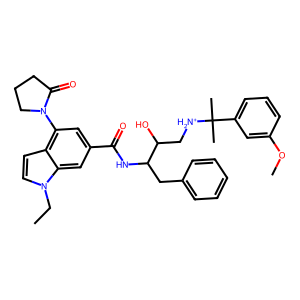

In [17]:
mol = Chem.MolFromSmiles(trainval_dataset_ecfp.ids[0])
Draw.MolToImage(mol)

### Class Imbalance

Check class imbalance to choose correct metric

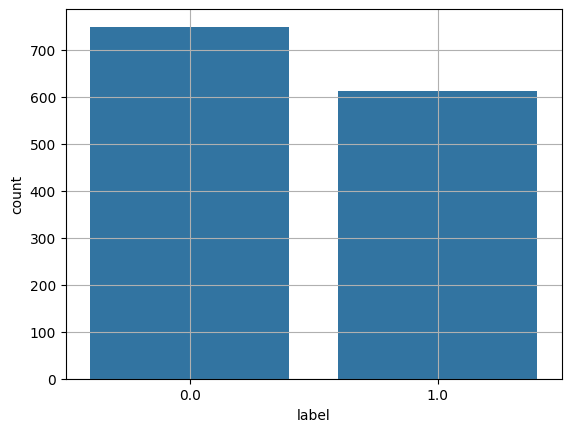

In [18]:
df = pd.DataFrame({'label': trainval_dataset_ecfp.y.ravel()})

sns.countplot(data=df, x='label')
plt.grid()

In [19]:
print(f"A/B ratio: {len(df[df['label'] == 1]) / len(df[df['label'] == 0])}")

A/B ratio: 0.8170894526034713


## Preprocessing

NaNs Check

In [20]:
print(np.isnan(trainval_dataset_ecfp.X).sum())
print(np.isnan(trainval_dataset_ecfp.y).sum())
print(np.isnan(trainval_dataset_ecfp.w).sum())

0
0
0


Remove Duplicates to get better generalization

In [21]:
_, unique_indices = np.unique(trainval_dataset_ecfp.X, axis=0, return_index=True)

print(f"Number of duplicates {trainval_dataset_ecfp.X.shape[0] - unique_indices.shape[0]}")

X_train = trainval_dataset_ecfp.X[unique_indices]
y_train = trainval_dataset_ecfp.y[unique_indices]
weights = trainval_dataset_ecfp.w[unique_indices]

Number of duplicates 28


Pairwise correlation analysis

In [22]:
mi = mutual_info_classif(X_train, y_train)

print(f"Max pairwise correlation: {mi.max()}")
print(f"Min pairwise correlation: {mi.min()}")

Max pairwise correlation: 0.07076722256433188
Min pairwise correlation: 0.0


## Model training

#### Classifiers and Parameters for GridSearch

In [23]:
models_and_params = [
    (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
    }),
    (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [0.1, 1, 10],
        'degree': [0, 1, 2, 3]
    }),
    (RandomForestClassifier(n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    }),
    (LGBMClassifier(boosting_type='gbdt', n_jobs=-1, verbose=-1), {
        'num_leaves': [16, 32],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1],
    }),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, tree_method='hist'), {
        'max_depth': [3, 6, 10],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1],
    })
]

Training models in Nested Cross Validation for Logistic Regression, SVC, Random Forest Classifier, LGBM Classifier, XGB Classifier

In [24]:
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Indices for every Nested Cross Validation.
fold_indices = []           
for train_idx, valid_idx in skf.split(X_train, y_train):
    fold_indices.append((train_idx, valid_idx))

nested_results = {}

# Models: {LogisticRegression, SVC, RandomForestClassifier, LGBMClassifier, XGBClassifier}
for model, param_grid in models_and_params:
    name = model.__class__.__name__
    print(f"Current model: {name}")

    val_scores = []                 # List for AUC's to compute mean
    best_params_all_folds = []      # Best parameters 

    # Cross Validation
    for fold, (train_idx, valid_idx) in enumerate(fold_indices):

        # Set split
        X_t, X_v = X_train[train_idx], X_train[valid_idx]
        y_t, y_v = y_train[train_idx], y_train[valid_idx]
        weights_cv = weights[train_idx]

        # Inner validation
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid = GridSearchCV(model, param_grid=param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)

        # Model train
        grid.fit(X_t, y_t, sample_weight=weights_cv.ravel())
        best_model = grid.best_estimator_
        best_params_all_folds.append(frozenset(grid.best_params_.items()))  # Select best parameters and add to list

        # Models' score
        y_pred = best_model.predict_proba(X_v)[:, 1]
        auc = roc_auc_score(y_v, y_pred)
        val_scores.append(auc)

    mean_score = np.mean(val_scores)                                            # Mean scores for currently model
    most_common_params = Counter(best_params_all_folds).most_common(1)[0][0]    # Save most common parameters

    # Saving results
    nested_results[name] = {
        'mean_auc': round(mean_score, 4),
        'most_common_params': dict(most_common_params)
    }

print("======= Nested CV scores =======")
for model_name, result in nested_results.items():
    print(f"\n{model_name}:")
    print(f"Mean ROC-AUC: {result['mean_auc']}")
    print(f"Most common params: {result['most_common_params']}")

Current model: LogisticRegression
Current model: SVC
Current model: RandomForestClassifier
Current model: LGBMClassifier
Current model: XGBClassifier
======= Nested CV scores =======

LogisticRegression:
Mean ROC-AUC: 0.9038
Most common params: {'penalty': 'l2', 'C': 0.1}

SVC:
Mean ROC-AUC: 0.9095
Most common params: {'kernel': 'poly', 'gamma': 0.1, 'C': 0.1, 'degree': 2}

RandomForestClassifier:
Mean ROC-AUC: 0.9047
Most common params: {'min_samples_split': 2, 'max_depth': None, 'n_estimators': 200}

LGBMClassifier:
Mean ROC-AUC: 0.9098
Most common params: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 32, 'reg_alpha': 0, 'reg_lambda': 0.1}

XGBClassifier:
Mean ROC-AUC: 0.9059
Most common params: {'max_depth': 10, 'reg_alpha': 1, 'learning_rate': 0.1, 'reg_lambda': 1, 'n_estimators': 200}


### Neural network

Model

In [25]:
def nn_model(input_shape):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(input_shape, sparse=True),

        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(2e-4)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(2e-4)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['AUC'])
    return model

Callbacks

In [26]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='auto',
    cooldown=0,
    min_lr=1e-6,
)

earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

Cross Validation for Neural Network

In [27]:
val_auc_scores_nn = []

# Cross Validation
for fold, (train_idx, valid_idx) in enumerate(fold_indices):
    
    # Sets split
    X_t, X_v = X_train[train_idx], X_train[valid_idx]
    y_t, y_v = y_train[train_idx].ravel(), y_train[valid_idx].ravel()
    weights_cv = weights[train_idx]

    # Data preprocessing
    train_cv_set = tf.data.Dataset.from_tensor_slices((X_t, y_t, weights_cv))
    valid_cv_set = tf.data.Dataset.from_tensor_slices((X_v, y_v))

    train_cv_set = train_cv_set.map(lambda x, y, w: (tf.cast(x, tf.float32), y, w)).batch(8)
    valid_cv_set = valid_cv_set.map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(8)

    # Neural Network
    model = nn_model(X_t.shape[1:])

    # Model train
    history = model.fit(train_cv_set, 
                        validation_data=valid_cv_set, 
                        epochs=20, 
                        callbacks=[ReduceLROnPlateau, earlyStopping], 
                        shuffle=True,)

    # Model's score
    y_val_pred = model.predict(X_v)
    val_auc = roc_auc_score(y_true=y_v, y_score=y_val_pred)
    val_auc_scores_nn.append(val_auc)
    print(f"Fold {fold + 1}, ROC-AUC: {val_auc:.4f}")

val_auc_mean_nn = round(np.mean(val_auc_scores_nn), 4)

# Scores printing
print("\nROC-AUC for fold:", [round(x, 4) for x in val_auc_scores_nn])
print("Mean ROC-AUC for validation:", val_auc_mean_nn)

2025-07-14 11:43:11.709703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 11:43:11.711008: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
134/134 [==============================] - 3s 18ms/step - loss: 1.4183 - auc: 0.4791 - val_loss: 0.6885 - val_auc: 0.6772 - lr: 1.0000e-04
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 1.3428 - auc: 0.6759 - val_loss: 0.6618 - val_auc: 0.7959 - lr: 1.0000e-04
Epoch 3/20
134/134 [==============================] - 3s 19ms/step - loss: 1.2827 - auc: 0.7564 - val_loss: 0.6250 - val_auc: 0.8375 - lr: 1.0000e-04
Epoch 4/20
134/134 [==============================] - 1s 9ms/step - loss: 1.2015 - auc: 0.8186 - val_loss: 0.5850 - val_auc: 0.8505 - lr: 1.0000e-04
Epoch 5/20
134/134 [==============================] - 1s 11ms/step - loss: 1.0907 - auc: 0.8673 - val_loss: 0.5400 - val_auc: 0.8599 - lr: 1.0000e-04
Epoch 6/20
134/134 [==============================] - 1s 6ms/step - loss: 1.0139 - auc: 0.8725 - val_loss: 0.5070 - val_auc: 0.8692 - lr: 1.0000e-04
Epoch 7/20
134/134 [==============================] - 2s 12ms/step - loss: 0.9402 - auc: 0.8854 - val_

### Graph Conv Model:


Data preprocessing for GraphConvModel.

In [28]:
graph_featurizer = ConvMolFeaturizer()

# Prepare sets for GraphConvModel
graph_train = graph_featurizer.featurize(train_dataset.X)
graph_valid = graph_featurizer.featurize(valid_dataset.X)

train_dataset_graph = NumpyDataset(graph_train, train_dataset.y, train_dataset.w, train_dataset.ids)
valid_dataset_graph = NumpyDataset(graph_valid, valid_dataset.y, valid_dataset.w, valid_dataset.ids)

# Concatenate Train set and Validation set
X_trainval = np.concatenate([train_dataset_graph.X, valid_dataset_graph.X], axis=0)
y_trainval = np.concatenate([train_dataset_graph.y, valid_dataset_graph.y], axis=0)
w_trainval = np.concatenate([train_dataset_graph.w, valid_dataset_graph.w], axis=0)
ids_trainval = np.concatenate([train_dataset_graph.ids, valid_dataset_graph.ids], axis=0)

# Concatenated Train and Validation sets
trainval_dataset_graph = NumpyDataset(X_trainval, y_trainval, w_trainval, ids_trainval)

Model

In [29]:
def graph_model(tasks):
    model = GraphConvModel(
        len(tasks), 
        batch_size=8,
        learning_rate=0.0001,
        mode='classification',
        dropout=0.1,
    )
    return model

Cross Validation

In [30]:
val_auc_scores_graph = []

# Model: GraphConvModel
for fold, (train_idx, valid_idx) in enumerate(fold_indices):
    
    print(f"\n --- Fold {fold + 1} ---")

    # Set split
    X_t, X_v = X_trainval[train_idx], X_trainval[valid_idx]
    y_t, y_v = y_trainval[train_idx].ravel(), y_trainval[valid_idx].ravel()
    weights_cv = weights[train_idx]

    # Data preprocessing
    train_fold = NumpyDataset(X_t, y_t, w=weights_cv)
    valid_fold = NumpyDataset(X_v, y_v)

    # GraphConvModel
    model = graph_model(tasks=tasks)

    # Model train
    history = model.fit(train_fold, nb_epoch=20)

    # Model's score
    X_v = NumpyDataset(X_v)
    y_val_pred_prob = model.predict(X_v)
    y_val_pred_prob = np.squeeze(y_val_pred_prob, axis=1)
    val_auc = roc_auc_score(y_true=y_v, y_score=y_val_pred_prob[:, 1])
    val_auc_scores_graph.append(val_auc)
    print(f"Fold {fold + 1}, AUC: {val_auc:.4f}")

val_auc_mean_graph = round(np.mean(val_auc_scores_graph), 4)  # Compute validation's scores mean

# Scores printing
print("AUC for fold:", [round(x, 4) for x in val_auc_scores_graph])
print("Mean AUC for validation:", val_auc_mean_graph)


 --- Fold 1 ---
Fold 1, AUC: 0.8643

 --- Fold 2 ---
Fold 2, AUC: 0.8650

 --- Fold 3 ---
Fold 3, AUC: 0.8532

 --- Fold 4 ---
Fold 4, AUC: 0.8159

 --- Fold 5 ---
Fold 5, AUC: 0.8297
AUC for fold: [0.8643, 0.865, 0.8532, 0.8159, 0.8297]
Mean AUC for validation: 0.8456


## All mean ROC-AUC scores

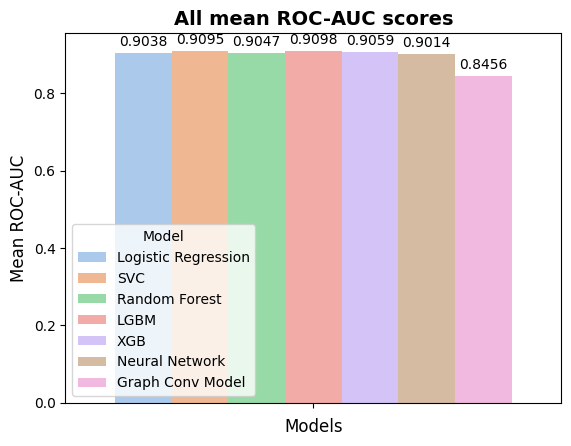

In [31]:
models_name = ['Logistic Regression', 'SVC', 'Random Forest', 'LGBM', "XGB", "Neural Network", "Graph Conv Model"]

# Models Scores
models_scores = []
for model_name, result in nested_results.items():
    models_scores.append(result['mean_auc'])
models_scores.append(val_auc_mean_nn)
models_scores.append(val_auc_mean_graph)

# Collect data to dict for plotting
scores_dict = {}
for i in range(len(models_name)):
    scores_dict[models_name[i]] = models_scores[i]
scores_dict = pd.DataFrame({'Model': models_name, 'Mean ROC AUC': models_scores} , index=np.arange(len(models_scores)))

# Plotting
ax = sns.barplot(data=scores_dict, hue='Model', y='Mean ROC AUC', palette="pastel")
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=10)
    
ax.set_title("All mean ROC-AUC scores", fontsize=14, weight='bold')
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Mean ROC-AUC", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='x', rotation=45)

## Best Model train & test on test set

In [33]:
#  The most frequently selected model parameters that performed best in multiple tests on different data subsets
best_model = LGBMClassifier(boosting_type='gbdt', n_jobs=-1, verbose=-1, n_estimators=100, learning_rate=0.1, num_leaves=32, reg_alpha=0, reg_lambda=0.1)
best_model.fit(X_train, y_train)

ecfp_test = ecfp_featurizer.featurize(test_dataset.X)
y_pred = best_model.predict_proba(ecfp_test)[:, 1]

print(f"Best model's roc-auc on test set: {roc_auc_score(y_true=test_dataset.y, y_score=y_pred)}")

Best model's roc-auc on test set: 0.9174614184151205


#### Save Model

In [ ]:
from joblib import dump

# save model
dump(best_model, 'model.joblib')

['model.joblib']